In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pickle
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchsummary import summary

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import sys
import time
import math
from tqdm import tqdm

In [2]:
seed = 1029
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# some cudnn methods can be random even after fixing the seed
# unless you tell it to be deterministic
torch.backends.cudnn.deterministic = True

In [3]:
import torch
class Cutout(object):
    """Randomly mask out one or more patches from an image.

    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [4]:
import torch
from torch.optim.optimizer import Optimizer
from torch.optim import Adam
from collections import defaultdict

class Lookahead(Optimizer):
    def __init__(self, base_optimizer, alpha=0.5, k=6):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        defaults = dict(lookahead_alpha=alpha, lookahead_k=k, lookahead_step=0)
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        self.defaults = base_optimizer.defaults
        self.defaults.update(defaults)
        self.state = defaultdict(dict)
        # manually add our defaults to the param groups
        for name, default in defaults.items():
            for group in self.param_groups:
                group.setdefault(name, default)

    def update_slow(self, group):
        for fast_p in group["params"]:
            if fast_p.grad is None:
                continue
            param_state = self.state[fast_p]
            if 'slow_buffer' not in param_state:
                param_state['slow_buffer'] = torch.empty_like(fast_p.data)
                param_state['slow_buffer'].copy_(fast_p.data)
            slow = param_state['slow_buffer']
            slow.add_(group['lookahead_alpha'], fast_p.data - slow)
            fast_p.data.copy_(slow)

    def sync_lookahead(self):
        for group in self.param_groups:
            self.update_slow(group)

    def step(self, closure=None):
        # print(self.k)
        #assert id(self.param_groups) == id(self.base_optimizer.param_groups)
        loss = self.base_optimizer.step(closure)
        for group in self.param_groups:
            group['lookahead_step'] += 1
            if group['lookahead_step'] % group['lookahead_k'] == 0:
                self.update_slow(group)
        return loss

    def state_dict(self):
        fast_state_dict = self.base_optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        fast_state = fast_state_dict['state']
        param_groups = fast_state_dict['param_groups']
        return {
            'state': fast_state,
            'slow_state': slow_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        fast_state_dict = {
            'state': state_dict['state'],
            'param_groups': state_dict['param_groups'],
        }
        self.base_optimizer.load_state_dict(fast_state_dict)

        # We want to restore the slow state, but share param_groups reference
        # with base_optimizer. This is a bit redundant but least code
        slow_state_new = False
        if 'slow_state' not in state_dict:
            print('Loading state_dict from optimizer without Lookahead applied.')
            state_dict['slow_state'] = defaultdict(dict)
            slow_state_new = True
        slow_state_dict = {
            'state': state_dict['slow_state'],
            'param_groups': state_dict['param_groups'],  # this is pointless but saves code
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.param_groups = self.base_optimizer.param_groups  # make both ref same container
        if slow_state_new:
            # reapply defaults to catch missing lookahead specific ones
            for name, default in self.defaults.items():
                for group in self.param_groups:
                    group.setdefault(name, default)

In [5]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_train_cutout = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    Cutout(n_holes=1, length=8)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


trainset = torchvision.datasets.CIFAR10(
    root='/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python', train=True, download=True, transform=transform_train_cutout)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=16)

testset = torchvision.datasets.CIFAR10(
    root='/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=16)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Files already downloaded and verified


In [6]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, kernel=3, shortcut_kernel=1, dropout = 0.0):
        super(BasicBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(p = dropout)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=shortcut_kernel, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        # Apply first convolution, batch norm, and ReLU
        out = self.dropout(F.relu(self.bn1(self.conv1(x))))
        # Apply second convolution and batch norm
        out = self.bn2(self.conv2(out))
        # Add shortcut connection
        out += self.shortcut(x)
        # Apply final ReLU
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, channels, strides, kernel_size, shortcut_kernel_size, pool_size, dropout, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = channels[0]
        self.kernel_size = kernel_size
        self.shortcut_kernel_size = shortcut_kernel_size
        self.pool_size = pool_size

        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels[0])

        self.dropout = nn.Dropout(p = dropout)

        self.layers = nn.ModuleList()
        for i in range(len(num_blocks)):
            self.layers.append(
                self._make_layer(block[i], channels[i], num_blocks[i], stride=strides[i], dropout = dropout)
            )

        # Fully connected layer
        self.linear = nn.Linear(channels[-1] * block[-1].expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride, dropout):
        strides = [stride] + [1] * (num_blocks - 1)  # First block uses the specified stride, others use stride=1
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride, self.kernel_size, self.shortcut_kernel_size, dropout))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # Apply initial convolution, batch norm, and ReLU
        out = self.dropout(F.relu(self.bn1(self.conv1(x))))

        # Pass through all layers
        for layer in self.layers:
            out = layer(out)

        # Apply average pooling and flatten
        out = F.avg_pool2d(out, self.pool_size)
        out = torch.flatten(out, 1)

        # Apply fully connected layer
        out = self.linear(out)
        return out

In [7]:
train_losses = []
gradients_norms = []
train_acc = []
test_losses_l1 = []
test_acc_l1 = []
best_acc = 0
plot_train_loss = []
plot_test_loss = []
plot_gradient_norms = []

In [8]:
def check_gradient_norms(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)  # L2 norm of gradients
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1.0 / 2)  # Total L2 norm
    return total_norm

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, eps=0.2, reduction='mean'):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.eps = eps
        self.reduction = reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum':
            loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':
                loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, reduction=self.reduction)

In [10]:
def train(model, device, train_loader, optimizer, epoch):
  model.to(device)
  model.train()
  pbar=tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss_accu = 0
  grad_norm_accu = 0
  criterion= LabelSmoothingCrossEntropy().to(device)
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
      
    # data, targets_a, targets_b, lam = mixup_data(data, target, 0.75)

    
    optimizer.zero_grad()
    y_pred = model(data)
    loss  = criterion(y_pred, target)
    # loss = mixup_criterion(criterion, y_pred, targets_a, targets_b, lam)
    train_loss_accu += loss.item()
    train_losses.append(loss)
    loss.backward()

    grad_norm = check_gradient_norms(model)
    grad_norm_accu += grad_norm
    gradients_norms.append(grad_norm)

    # nn.utils.clip_grad_value_(model.parameters(), clip_value = 0.1)
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Accuracy={100*correct/processed:0.2f} Gradient Norm={grad_norm:0.2f}')
  train_acc.append(100*correct/processed)
  plot_train_loss.append(train_loss_accu/len(train_loader))
  plot_gradient_norms.append(grad_norm_accu/len(train_loader))
  print(f'Epoch Loss={train_loss_accu/len(train_loader):0.2f} Accuracy={100*correct/processed:0.2f} Gradient Norm={grad_norm_accu/len(train_loader):0.2f}')

In [11]:
def test(model, device, test_loader):
    model.eval()
    average_test_loss = 0
    test_loss = 0
    correct = 0
    global best_acc
    criterion= LabelSmoothingCrossEntropy().to(device)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    average_test_loss = test_loss / len(test_loader)
    test_losses_l1.append(average_test_loss)
    print('\nTest set: Test loss: {:.4f}, Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(test_loss, average_test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc_l1.append(100. * correct / len(test_loader.dataset))
    if 100. * correct / len(test_loader.dataset) > best_acc:
        model.cpu()
        model_scripted = torch.jit.script(model)
        model_scripted.save('./Resnet_v23.pth')
        print("Saved Model")
        best_acc = 100. * correct / len(test_loader.dataset)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [13]:
model = ResNet([BasicBlock, BasicBlock, BasicBlock], [4, 5, 3], [64, 128, 256], [1, 2, 2], 3, 1, 8, 0.0).to(device)

In [14]:
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
           Dropout-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
           Dropout-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [15]:
epochs = 200
lr = 0.1
momentum = 0.9
weight_decay = 5e-04
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum, weight_decay = weight_decay)
optimizer = Lookahead(optimizer, k=5, alpha=0.5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 200)

In [16]:
for epoch in range(epochs):
    print(f'Epoch: {epoch} Learning Rate {optimizer.param_groups[0]["lr"]}')
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)
    scheduler.step()

Epoch: 0 Learning Rate 0.1


Loss=3.62678861618042 Accuracy=10.74 Gradient Norm=8.18:   1%|          | 4/391 [00:02<02:54,  2.22it/s]<ipython-input-4-4f13049556b0>:32: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1642.)
  slow.add_(group['lookahead_alpha'], fast_p.data - slow)
Loss=2.033759355545044 Accuracy=25.50 Gradient Norm=1.41: 100%|██████████| 391/391 [00:45<00:00,  8.53it/s]

Epoch Loss=2.13 Accuracy=25.50 Gradient Norm=1.06



Test set: Test loss: 188.2288, Average loss: 1.8823, Accuracy: 3885/10000 (38.8500%)

Saved Model
Epoch: 1 Learning Rate 0.09999383162408304


Loss=1.7000502347946167 Accuracy=40.45 Gradient Norm=1.57: 100%|██████████| 391/391 [00:45<00:00,  8.62it/s]

Epoch Loss=1.89 Accuracy=40.45 Gradient Norm=1.08



Test set: Test loss: 179.8175, Average loss: 1.7982, Accuracy: 4802/10000 (48.0200%)

Saved Model
Epoch: 2 Learning Rate 0.09997532801828658


Loss=1.586949110031128 Accuracy=50.00 Gradient Norm=1.46: 100%|██████████| 391/391 [00:45<00:00,  8.57it/s]

Epoch Loss=1.74 Accuracy=50.00 Gradient Norm=1.15



Test set: Test loss: 172.2378, Average loss: 1.7224, Accuracy: 5270/10000 (52.7000%)

Saved Model
Epoch: 3 Learning Rate 0.09994449374809851


Loss=1.6235811710357666 Accuracy=56.76 Gradient Norm=1.60: 100%|██████████| 391/391 [00:45<00:00,  8.56it/s]

Epoch Loss=1.64 Accuracy=56.76 Gradient Norm=1.17



Test set: Test loss: 167.0357, Average loss: 1.6704, Accuracy: 5841/10000 (58.4100%)

Saved Model
Epoch: 4 Learning Rate 0.09990133642141359


Loss=1.6827633380889893 Accuracy=61.78 Gradient Norm=1.66: 100%|██████████| 391/391 [00:45<00:00,  8.57it/s]

Epoch Loss=1.56 Accuracy=61.78 Gradient Norm=1.20



Test set: Test loss: 133.9822, Average loss: 1.3398, Accuracy: 7491/10000 (74.9100%)

Saved Model
Epoch: 5 Learning Rate 0.09984586668665642


Loss=1.4033472537994385 Accuracy=66.24 Gradient Norm=1.44: 100%|██████████| 391/391 [00:45<00:00,  8.57it/s]

Epoch Loss=1.48 Accuracy=66.24 Gradient Norm=1.23



Test set: Test loss: 130.8828, Average loss: 1.3088, Accuracy: 7648/10000 (76.4800%)

Saved Model
Epoch: 6 Learning Rate 0.09977809823015402


Loss=1.4015835523605347 Accuracy=69.53 Gradient Norm=1.41: 100%|██████████| 391/391 [00:46<00:00,  8.50it/s]

Epoch Loss=1.42 Accuracy=69.53 Gradient Norm=1.21



Test set: Test loss: 133.2381, Average loss: 1.3324, Accuracy: 7605/10000 (76.0500%)

Epoch: 7 Learning Rate 0.09969804777275901


Loss=1.469021201133728 Accuracy=71.96 Gradient Norm=1.73: 100%|██████████| 391/391 [00:45<00:00,  8.56it/s]

Epoch Loss=1.38 Accuracy=71.96 Gradient Norm=1.22



Test set: Test loss: 137.7482, Average loss: 1.3775, Accuracy: 7421/10000 (74.2100%)

Epoch: 8 Learning Rate 0.09960573506572391


Loss=1.4404034614562988 Accuracy=73.43 Gradient Norm=1.68: 100%|██████████| 391/391 [00:45<00:00,  8.56it/s]

Epoch Loss=1.35 Accuracy=73.43 Gradient Norm=1.23



Test set: Test loss: 138.1672, Average loss: 1.3817, Accuracy: 7235/10000 (72.3500%)

Epoch: 9 Learning Rate 0.09950118288582789


Loss=1.4563403129577637 Accuracy=75.09 Gradient Norm=1.47: 100%|██████████| 391/391 [00:45<00:00,  8.62it/s]

Epoch Loss=1.33 Accuracy=75.09 Gradient Norm=1.23



Test set: Test loss: 121.0521, Average loss: 1.2105, Accuracy: 8188/10000 (81.8800%)

Saved Model
Epoch: 10 Learning Rate 0.09938441702975691


Loss=1.2878532409667969 Accuracy=76.50 Gradient Norm=1.55: 100%|██████████| 391/391 [00:46<00:00,  8.48it/s]

Epoch Loss=1.30 Accuracy=76.50 Gradient Norm=1.24



Test set: Test loss: 117.8827, Average loss: 1.1788, Accuracy: 8360/10000 (83.6000%)

Saved Model
Epoch: 11 Learning Rate 0.09925546630773871


Loss=1.2503379583358765 Accuracy=77.41 Gradient Norm=1.29: 100%|██████████| 391/391 [00:45<00:00,  8.55it/s]

Epoch Loss=1.28 Accuracy=77.41 Gradient Norm=1.26



Test set: Test loss: 139.5750, Average loss: 1.3957, Accuracy: 7196/10000 (71.9600%)

Epoch: 12 Learning Rate 0.09911436253643445


Loss=1.328446388244629 Accuracy=78.33 Gradient Norm=1.67: 100%|██████████| 391/391 [00:45<00:00,  8.61it/s]

Epoch Loss=1.27 Accuracy=78.33 Gradient Norm=1.27



Test set: Test loss: 131.8417, Average loss: 1.3184, Accuracy: 7690/10000 (76.9000%)

Epoch: 13 Learning Rate 0.0989611405310883


Loss=1.3429466485977173 Accuracy=79.03 Gradient Norm=1.62: 100%|██████████| 391/391 [00:45<00:00,  8.58it/s]

Epoch Loss=1.25 Accuracy=79.03 Gradient Norm=1.26



Test set: Test loss: 125.9534, Average loss: 1.2595, Accuracy: 7993/10000 (79.9300%)

Epoch: 14 Learning Rate 0.09879583809693739


Loss=1.2799444198608398 Accuracy=79.75 Gradient Norm=1.69: 100%|██████████| 391/391 [00:45<00:00,  8.62it/s]

Epoch Loss=1.25 Accuracy=79.75 Gradient Norm=1.29



Test set: Test loss: 111.6268, Average loss: 1.1163, Accuracy: 8723/10000 (87.2300%)

Saved Model
Epoch: 15 Learning Rate 0.09861849601988384


Loss=1.3612624406814575 Accuracy=79.95 Gradient Norm=1.78: 100%|██████████| 391/391 [00:45<00:00,  8.52it/s]

Epoch Loss=1.24 Accuracy=79.95 Gradient Norm=1.32



Test set: Test loss: 115.0933, Average loss: 1.1509, Accuracy: 8533/10000 (85.3300%)

Epoch: 16 Learning Rate 0.09842915805643157


Loss=1.2390273809432983 Accuracy=80.51 Gradient Norm=1.49: 100%|██████████| 391/391 [00:46<00:00,  8.48it/s]

Epoch Loss=1.23 Accuracy=80.51 Gradient Norm=1.33



Test set: Test loss: 124.6263, Average loss: 1.2463, Accuracy: 8027/10000 (80.2700%)

Epoch: 17 Learning Rate 0.09822787092288993


Loss=1.2360084056854248 Accuracy=81.00 Gradient Norm=2.11: 100%|██████████| 391/391 [00:45<00:00,  8.53it/s]

Epoch Loss=1.22 Accuracy=81.00 Gradient Norm=1.35



Test set: Test loss: 117.3587, Average loss: 1.1736, Accuracy: 8372/10000 (83.7200%)

Epoch: 18 Learning Rate 0.09801468428384717


Loss=1.2686278820037842 Accuracy=81.31 Gradient Norm=1.73: 100%|██████████| 391/391 [00:45<00:00,  8.55it/s]

Epoch Loss=1.22 Accuracy=81.31 Gradient Norm=1.35



Test set: Test loss: 117.1830, Average loss: 1.1718, Accuracy: 8420/10000 (84.2000%)

Epoch: 19 Learning Rate 0.09778965073991652


Loss=1.228946328163147 Accuracy=81.45 Gradient Norm=1.49: 100%|██████████| 391/391 [00:45<00:00,  8.56it/s]

Epoch Loss=1.21 Accuracy=81.45 Gradient Norm=1.37



Test set: Test loss: 109.9566, Average loss: 1.0996, Accuracy: 8815/10000 (88.1500%)

Saved Model
Epoch: 20 Learning Rate 0.0975528258147577


Loss=1.2699978351593018 Accuracy=81.81 Gradient Norm=1.91: 100%|██████████| 391/391 [00:45<00:00,  8.50it/s]

Epoch Loss=1.20 Accuracy=81.81 Gradient Norm=1.36



Test set: Test loss: 115.2744, Average loss: 1.1527, Accuracy: 8520/10000 (85.2000%)

Epoch: 21 Learning Rate 0.09730426794137728


Loss=1.1438164710998535 Accuracy=81.82 Gradient Norm=1.48: 100%|██████████| 391/391 [00:46<00:00,  8.43it/s]

Epoch Loss=1.20 Accuracy=81.82 Gradient Norm=1.39



Test set: Test loss: 111.2979, Average loss: 1.1130, Accuracy: 8730/10000 (87.3000%)

Epoch: 22 Learning Rate 0.09704403844771128


Loss=1.2432444095611572 Accuracy=82.55 Gradient Norm=1.71: 100%|██████████| 391/391 [00:45<00:00,  8.54it/s]

Epoch Loss=1.19 Accuracy=82.55 Gradient Norm=1.39



Test set: Test loss: 127.9672, Average loss: 1.2797, Accuracy: 7965/10000 (79.6500%)

Epoch: 23 Learning Rate 0.09677220154149338


Loss=1.1857821941375732 Accuracy=82.57 Gradient Norm=1.81: 100%|██████████| 391/391 [00:46<00:00,  8.47it/s]

Epoch Loss=1.19 Accuracy=82.57 Gradient Norm=1.41



Test set: Test loss: 115.4892, Average loss: 1.1549, Accuracy: 8548/10000 (85.4800%)

Epoch: 24 Learning Rate 0.09648882429441258


Loss=1.2697958946228027 Accuracy=82.87 Gradient Norm=1.91: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]

Epoch Loss=1.19 Accuracy=82.87 Gradient Norm=1.41



Test set: Test loss: 107.7131, Average loss: 1.0771, Accuracy: 8894/10000 (88.9400%)

Saved Model
Epoch: 25 Learning Rate 0.09619397662556435


Loss=1.15329909324646 Accuracy=83.16 Gradient Norm=1.59: 100%|██████████| 391/391 [00:46<00:00,  8.50it/s]

Epoch Loss=1.18 Accuracy=83.16 Gradient Norm=1.40



Test set: Test loss: 107.9872, Average loss: 1.0799, Accuracy: 8887/10000 (88.8700%)

Epoch: 26 Learning Rate 0.09588773128419906


Loss=1.1381523609161377 Accuracy=83.31 Gradient Norm=1.81: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]

Epoch Loss=1.18 Accuracy=83.31 Gradient Norm=1.42



Test set: Test loss: 112.0824, Average loss: 1.1208, Accuracy: 8690/10000 (86.9000%)

Epoch: 27 Learning Rate 0.09557016383177226


Loss=1.1824235916137695 Accuracy=83.32 Gradient Norm=1.94: 100%|██████████| 391/391 [00:46<00:00,  8.37it/s]

Epoch Loss=1.18 Accuracy=83.32 Gradient Norm=1.42



Test set: Test loss: 120.3388, Average loss: 1.2034, Accuracy: 8180/10000 (81.8000%)

Epoch: 28 Learning Rate 0.09524135262330098


Loss=1.114093542098999 Accuracy=83.97 Gradient Norm=1.68: 100%|██████████| 391/391 [00:45<00:00,  8.52it/s]

Epoch Loss=1.17 Accuracy=83.97 Gradient Norm=1.42



Test set: Test loss: 150.0711, Average loss: 1.5007, Accuracy: 6868/10000 (68.6800%)

Epoch: 29 Learning Rate 0.09490137878803079


Loss=1.242118000984192 Accuracy=83.83 Gradient Norm=2.04: 100%|██████████| 391/391 [00:45<00:00,  8.52it/s]

Epoch Loss=1.17 Accuracy=83.83 Gradient Norm=1.43



Test set: Test loss: 105.8526, Average loss: 1.0585, Accuracy: 9034/10000 (90.3400%)

Saved Model
Epoch: 30 Learning Rate 0.0945503262094184


Loss=1.058623194694519 Accuracy=84.05 Gradient Norm=1.41: 100%|██████████| 391/391 [00:46<00:00,  8.47it/s]

Epoch Loss=1.16 Accuracy=84.05 Gradient Norm=1.43



Test set: Test loss: 107.9079, Average loss: 1.0791, Accuracy: 8886/10000 (88.8600%)

Epoch: 31 Learning Rate 0.0941882815044347


Loss=1.251667857170105 Accuracy=84.08 Gradient Norm=1.82: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]

Epoch Loss=1.16 Accuracy=84.08 Gradient Norm=1.44



Test set: Test loss: 116.7730, Average loss: 1.1677, Accuracy: 8416/10000 (84.1600%)

Epoch: 32 Learning Rate 0.09381533400219319


Loss=1.1769843101501465 Accuracy=84.06 Gradient Norm=1.97: 100%|██████████| 391/391 [00:46<00:00,  8.48it/s]

Epoch Loss=1.16 Accuracy=84.06 Gradient Norm=1.45



Test set: Test loss: 114.9244, Average loss: 1.1492, Accuracy: 8534/10000 (85.3400%)

Epoch: 33 Learning Rate 0.09343157572190958


Loss=1.1926312446594238 Accuracy=84.24 Gradient Norm=1.79: 100%|██████████| 391/391 [00:45<00:00,  8.52it/s]

Epoch Loss=1.16 Accuracy=84.24 Gradient Norm=1.45



Test set: Test loss: 115.9629, Average loss: 1.1596, Accuracy: 8493/10000 (84.9300%)

Epoch: 34 Learning Rate 0.0930371013501972


Loss=1.149301290512085 Accuracy=84.54 Gradient Norm=1.68: 100%|██████████| 391/391 [00:46<00:00,  8.48it/s]

Epoch Loss=1.16 Accuracy=84.54 Gradient Norm=1.45



Test set: Test loss: 104.9572, Average loss: 1.0496, Accuracy: 9053/10000 (90.5300%)

Saved Model
Epoch: 35 Learning Rate 0.09263200821770463


Loss=1.1271977424621582 Accuracy=84.78 Gradient Norm=1.69: 100%|██████████| 391/391 [00:46<00:00,  8.49it/s]

Epoch Loss=1.15 Accuracy=84.78 Gradient Norm=1.45



Test set: Test loss: 108.3943, Average loss: 1.0839, Accuracy: 8893/10000 (88.9300%)

Epoch: 36 Learning Rate 0.09221639627510078


Loss=1.1992911100387573 Accuracy=84.95 Gradient Norm=1.73: 100%|██████████| 391/391 [00:46<00:00,  8.43it/s]

Epoch Loss=1.15 Accuracy=84.95 Gradient Norm=1.47



Test set: Test loss: 109.7757, Average loss: 1.0978, Accuracy: 8794/10000 (87.9400%)

Epoch: 37 Learning Rate 0.09179036806841355


Loss=1.2117369174957275 Accuracy=85.00 Gradient Norm=1.96: 100%|██████████| 391/391 [00:46<00:00,  8.40it/s]

Epoch Loss=1.15 Accuracy=85.00 Gradient Norm=1.47



Test set: Test loss: 122.3452, Average loss: 1.2235, Accuracy: 8153/10000 (81.5300%)

Epoch: 38 Learning Rate 0.09135402871372812


Loss=1.1760952472686768 Accuracy=85.06 Gradient Norm=2.14: 100%|██████████| 391/391 [00:46<00:00,  8.44it/s]

Epoch Loss=1.15 Accuracy=85.06 Gradient Norm=1.47



Test set: Test loss: 113.8368, Average loss: 1.1384, Accuracy: 8579/10000 (85.7900%)

Epoch: 39 Learning Rate 0.0909074858712512


Loss=1.1089078187942505 Accuracy=85.25 Gradient Norm=1.72: 100%|██████████| 391/391 [00:46<00:00,  8.49it/s]

Epoch Loss=1.14 Accuracy=85.25 Gradient Norm=1.47



Test set: Test loss: 104.4434, Average loss: 1.0444, Accuracy: 9102/10000 (91.0200%)

Saved Model
Epoch: 40 Learning Rate 0.09045084971874741


Loss=1.0638622045516968 Accuracy=85.15 Gradient Norm=1.43: 100%|██████████| 391/391 [00:46<00:00,  8.41it/s]

Epoch Loss=1.14 Accuracy=85.15 Gradient Norm=1.50



Test set: Test loss: 105.2371, Average loss: 1.0524, Accuracy: 9057/10000 (90.5700%)

Epoch: 41 Learning Rate 0.08998423292435458


Loss=1.0799702405929565 Accuracy=85.36 Gradient Norm=1.67: 100%|██████████| 391/391 [00:46<00:00,  8.49it/s]

Epoch Loss=1.14 Accuracy=85.36 Gradient Norm=1.46



Test set: Test loss: 107.2857, Average loss: 1.0729, Accuracy: 8947/10000 (89.4700%)

Epoch: 42 Learning Rate 0.08950775061878455


Loss=1.093400001525879 Accuracy=85.66 Gradient Norm=1.71: 100%|██████████| 391/391 [00:46<00:00,  8.42it/s]

Epoch Loss=1.14 Accuracy=85.66 Gradient Norm=1.47



Test set: Test loss: 107.5554, Average loss: 1.0756, Accuracy: 8918/10000 (89.1800%)

Epoch: 43 Learning Rate 0.08902152036691653


Loss=1.1762523651123047 Accuracy=85.70 Gradient Norm=1.94: 100%|██████████| 391/391 [00:46<00:00,  8.42it/s]

Epoch Loss=1.13 Accuracy=85.70 Gradient Norm=1.48



Test set: Test loss: 127.4573, Average loss: 1.2746, Accuracy: 7925/10000 (79.2500%)

Epoch: 44 Learning Rate 0.08852566213878951


Loss=1.164695143699646 Accuracy=85.64 Gradient Norm=1.88: 100%|██████████| 391/391 [00:46<00:00,  8.40it/s]

Epoch Loss=1.14 Accuracy=85.64 Gradient Norm=1.48



Test set: Test loss: 103.3085, Average loss: 1.0331, Accuracy: 9165/10000 (91.6500%)

Saved Model
Epoch: 45 Learning Rate 0.0880202982800016


Loss=1.0766003131866455 Accuracy=85.74 Gradient Norm=1.66: 100%|██████████| 391/391 [00:46<00:00,  8.47it/s]

Epoch Loss=1.13 Accuracy=85.74 Gradient Norm=1.50



Test set: Test loss: 110.0727, Average loss: 1.1007, Accuracy: 8848/10000 (88.4800%)

Epoch: 46 Learning Rate 0.08750555348152303


Loss=1.0503594875335693 Accuracy=85.91 Gradient Norm=1.76: 100%|██████████| 391/391 [00:46<00:00,  8.45it/s]

Epoch Loss=1.13 Accuracy=85.91 Gradient Norm=1.49



Test set: Test loss: 110.6929, Average loss: 1.1069, Accuracy: 8799/10000 (87.9900%)

Epoch: 47 Learning Rate 0.08698155474893052


Loss=1.0878652334213257 Accuracy=86.12 Gradient Norm=1.59: 100%|██████████| 391/391 [00:46<00:00,  8.43it/s]

Epoch Loss=1.13 Accuracy=86.12 Gradient Norm=1.50



Test set: Test loss: 114.1262, Average loss: 1.1413, Accuracy: 8579/10000 (85.7900%)

Epoch: 48 Learning Rate 0.08644843137107061


Loss=1.1959166526794434 Accuracy=85.92 Gradient Norm=2.23: 100%|██████████| 391/391 [00:46<00:00,  8.43it/s]

Epoch Loss=1.13 Accuracy=85.92 Gradient Norm=1.52



Test set: Test loss: 113.7987, Average loss: 1.1380, Accuracy: 8634/10000 (86.3400%)

Epoch: 49 Learning Rate 0.08590631488815947


Loss=1.1275582313537598 Accuracy=86.37 Gradient Norm=1.87: 100%|██████████| 391/391 [00:46<00:00,  8.45it/s]

Epoch Loss=1.12 Accuracy=86.37 Gradient Norm=1.50



Test set: Test loss: 103.9597, Average loss: 1.0396, Accuracy: 9089/10000 (90.8900%)

Epoch: 50 Learning Rate 0.0853553390593274


Loss=1.2093515396118164 Accuracy=86.31 Gradient Norm=1.94: 100%|██████████| 391/391 [00:46<00:00,  8.46it/s]

Epoch Loss=1.12 Accuracy=86.31 Gradient Norm=1.53



Test set: Test loss: 107.7280, Average loss: 1.0773, Accuracy: 8952/10000 (89.5200%)

Epoch: 51 Learning Rate 0.08479563982961574


Loss=1.0793840885162354 Accuracy=86.57 Gradient Norm=1.71: 100%|██████████| 391/391 [00:46<00:00,  8.43it/s]

Epoch Loss=1.12 Accuracy=86.57 Gradient Norm=1.51



Test set: Test loss: 108.0816, Average loss: 1.0808, Accuracy: 8915/10000 (89.1500%)

Epoch: 52 Learning Rate 0.08422735529643446


Loss=0.9913668632507324 Accuracy=86.65 Gradient Norm=1.55: 100%|██████████| 391/391 [00:46<00:00,  8.38it/s]

Epoch Loss=1.12 Accuracy=86.65 Gradient Norm=1.53



Test set: Test loss: 113.6870, Average loss: 1.1369, Accuracy: 8609/10000 (86.0900%)

Epoch: 53 Learning Rate 0.08365062567548869


Loss=1.1540199518203735 Accuracy=86.52 Gradient Norm=1.82: 100%|██████████| 391/391 [00:46<00:00,  8.45it/s]

Epoch Loss=1.12 Accuracy=86.52 Gradient Norm=1.52



Test set: Test loss: 111.5503, Average loss: 1.1155, Accuracy: 8752/10000 (87.5200%)

Epoch: 54 Learning Rate 0.08306559326618261


Loss=1.130167007446289 Accuracy=86.49 Gradient Norm=1.97: 100%|██████████| 391/391 [00:46<00:00,  8.38it/s]

Epoch Loss=1.12 Accuracy=86.49 Gradient Norm=1.54



Test set: Test loss: 102.8398, Average loss: 1.0284, Accuracy: 9179/10000 (91.7900%)

Saved Model
Epoch: 55 Learning Rate 0.0824724024165092


Loss=1.0774486064910889 Accuracy=86.75 Gradient Norm=1.81: 100%|██████████| 391/391 [00:46<00:00,  8.40it/s]

Epoch Loss=1.12 Accuracy=86.75 Gradient Norm=1.53



Test set: Test loss: 105.1109, Average loss: 1.0511, Accuracy: 9058/10000 (90.5800%)

Epoch: 56 Learning Rate 0.0818711994874345


Loss=1.1306031942367554 Accuracy=86.84 Gradient Norm=1.86: 100%|██████████| 391/391 [00:46<00:00,  8.36it/s]

Epoch Loss=1.12 Accuracy=86.84 Gradient Norm=1.53



Test set: Test loss: 105.0988, Average loss: 1.0510, Accuracy: 9046/10000 (90.4600%)

Epoch: 57 Learning Rate 0.08126213281678528


Loss=1.096834659576416 Accuracy=86.68 Gradient Norm=1.78: 100%|██████████| 391/391 [00:46<00:00,  8.42it/s]

Epoch Loss=1.11 Accuracy=86.68 Gradient Norm=1.54



Test set: Test loss: 109.8102, Average loss: 1.0981, Accuracy: 8803/10000 (88.0300%)

Epoch: 58 Learning Rate 0.08064535268264884


Loss=1.0524386167526245 Accuracy=86.79 Gradient Norm=1.77: 100%|██████████| 391/391 [00:46<00:00,  8.40it/s]

Epoch Loss=1.11 Accuracy=86.79 Gradient Norm=1.55



Test set: Test loss: 119.1079, Average loss: 1.1911, Accuracy: 8318/10000 (83.1800%)

Epoch: 59 Learning Rate 0.08002101126629421


Loss=1.0376664400100708 Accuracy=86.92 Gradient Norm=2.03: 100%|██████████| 391/391 [00:46<00:00,  8.42it/s]

Epoch Loss=1.11 Accuracy=86.92 Gradient Norm=1.57



Test set: Test loss: 103.2967, Average loss: 1.0330, Accuracy: 9139/10000 (91.3900%)

Epoch: 60 Learning Rate 0.07938926261462367


Loss=1.0556154251098633 Accuracy=86.86 Gradient Norm=2.16: 100%|██████████| 391/391 [00:46<00:00,  8.43it/s]

Epoch Loss=1.11 Accuracy=86.86 Gradient Norm=1.55



Test set: Test loss: 103.6071, Average loss: 1.0361, Accuracy: 9126/10000 (91.2600%)

Epoch: 61 Learning Rate 0.07875026260216395


Loss=1.0340564250946045 Accuracy=87.21 Gradient Norm=1.55: 100%|██████████| 391/391 [00:46<00:00,  8.43it/s]

Epoch Loss=1.11 Accuracy=87.21 Gradient Norm=1.57



Test set: Test loss: 111.7643, Average loss: 1.1176, Accuracy: 8686/10000 (86.8600%)

Epoch: 62 Learning Rate 0.07810416889260656


Loss=1.0581638813018799 Accuracy=87.00 Gradient Norm=1.49: 100%|██████████| 391/391 [00:46<00:00,  8.38it/s]

Epoch Loss=1.11 Accuracy=87.00 Gradient Norm=1.56



Test set: Test loss: 111.2073, Average loss: 1.1121, Accuracy: 8765/10000 (87.6500%)

Epoch: 63 Learning Rate 0.07745114089990661


Loss=1.0583680868148804 Accuracy=87.29 Gradient Norm=1.84: 100%|██████████| 391/391 [00:46<00:00,  8.38it/s]

Epoch Loss=1.10 Accuracy=87.29 Gradient Norm=1.56



Test set: Test loss: 106.7721, Average loss: 1.0677, Accuracy: 8938/10000 (89.3800%)

Epoch: 64 Learning Rate 0.07679133974894985


Loss=1.0831544399261475 Accuracy=87.20 Gradient Norm=1.59: 100%|██████████| 391/391 [00:46<00:00,  8.36it/s]

Epoch Loss=1.10 Accuracy=87.20 Gradient Norm=1.59



Test set: Test loss: 102.2924, Average loss: 1.0229, Accuracy: 9192/10000 (91.9200%)

Saved Model
Epoch: 65 Learning Rate 0.07612492823579746


Loss=1.0380381345748901 Accuracy=87.45 Gradient Norm=1.63: 100%|██████████| 391/391 [00:46<00:00,  8.35it/s]

Epoch Loss=1.10 Accuracy=87.45 Gradient Norm=1.58



Test set: Test loss: 104.1181, Average loss: 1.0412, Accuracy: 9119/10000 (91.1900%)

Epoch: 66 Learning Rate 0.07545207078751859


Loss=1.1063824892044067 Accuracy=87.52 Gradient Norm=2.30: 100%|██████████| 391/391 [00:46<00:00,  8.34it/s]

Epoch Loss=1.10 Accuracy=87.52 Gradient Norm=1.59



Test set: Test loss: 106.9055, Average loss: 1.0691, Accuracy: 8971/10000 (89.7100%)

Epoch: 67 Learning Rate 0.0747729334216204


Loss=1.08445405960083 Accuracy=87.45 Gradient Norm=2.02: 100%|██████████| 391/391 [00:46<00:00,  8.39it/s]

Epoch Loss=1.10 Accuracy=87.45 Gradient Norm=1.59



Test set: Test loss: 105.6450, Average loss: 1.0565, Accuracy: 9024/10000 (90.2400%)

Epoch: 68 Learning Rate 0.07408768370508578


Loss=1.1195294857025146 Accuracy=87.66 Gradient Norm=2.07: 100%|██████████| 391/391 [00:47<00:00,  8.32it/s]

Epoch Loss=1.10 Accuracy=87.66 Gradient Norm=1.59



Test set: Test loss: 105.0032, Average loss: 1.0500, Accuracy: 9053/10000 (90.5300%)

Epoch: 69 Learning Rate 0.0733964907130287


Loss=1.1653939485549927 Accuracy=87.82 Gradient Norm=2.44: 100%|██████████| 391/391 [00:46<00:00,  8.36it/s]

Epoch Loss=1.10 Accuracy=87.82 Gradient Norm=1.60



Test set: Test loss: 101.1529, Average loss: 1.0115, Accuracy: 9260/10000 (92.6000%)

Saved Model
Epoch: 70 Learning Rate 0.07269952498697736


Loss=1.1160954236984253 Accuracy=87.75 Gradient Norm=1.73: 100%|██████████| 391/391 [00:46<00:00,  8.39it/s]

Epoch Loss=1.10 Accuracy=87.75 Gradient Norm=1.61



Test set: Test loss: 101.4401, Average loss: 1.0144, Accuracy: 9225/10000 (92.2500%)

Epoch: 71 Learning Rate 0.07199695849279578


Loss=1.1186424493789673 Accuracy=87.84 Gradient Norm=1.88: 100%|██████████| 391/391 [00:46<00:00,  8.36it/s]

Epoch Loss=1.09 Accuracy=87.84 Gradient Norm=1.62



Test set: Test loss: 102.1942, Average loss: 1.0219, Accuracy: 9191/10000 (91.9100%)

Epoch: 72 Learning Rate 0.07128896457825366


Loss=1.063071846961975 Accuracy=88.08 Gradient Norm=1.64: 100%|██████████| 391/391 [00:46<00:00,  8.38it/s]

Epoch Loss=1.09 Accuracy=88.08 Gradient Norm=1.62



Test set: Test loss: 107.3392, Average loss: 1.0734, Accuracy: 8951/10000 (89.5100%)

Epoch: 73 Learning Rate 0.07057571793025548


Loss=1.177841305732727 Accuracy=88.17 Gradient Norm=2.13: 100%|██████████| 391/391 [00:46<00:00,  8.34it/s]

Epoch Loss=1.09 Accuracy=88.17 Gradient Norm=1.59



Test set: Test loss: 109.4327, Average loss: 1.0943, Accuracy: 8862/10000 (88.6200%)

Epoch: 74 Learning Rate 0.06985739453173906


Loss=1.0872819423675537 Accuracy=88.16 Gradient Norm=1.94: 100%|██████████| 391/391 [00:47<00:00,  8.27it/s]

Epoch Loss=1.09 Accuracy=88.16 Gradient Norm=1.63



Test set: Test loss: 102.4771, Average loss: 1.0248, Accuracy: 9202/10000 (92.0200%)

Epoch: 75 Learning Rate 0.06913417161825453


Loss=0.9926444292068481 Accuracy=88.36 Gradient Norm=1.83: 100%|██████████| 391/391 [00:46<00:00,  8.38it/s]

Epoch Loss=1.09 Accuracy=88.36 Gradient Norm=1.64



Test set: Test loss: 105.7675, Average loss: 1.0577, Accuracy: 8987/10000 (89.8700%)

Epoch: 76 Learning Rate 0.06840622763423394


Loss=1.1055904626846313 Accuracy=88.17 Gradient Norm=1.82: 100%|██████████| 391/391 [00:46<00:00,  8.34it/s]

Epoch Loss=1.09 Accuracy=88.17 Gradient Norm=1.64



Test set: Test loss: 107.9808, Average loss: 1.0798, Accuracy: 8898/10000 (88.9800%)

Epoch: 77 Learning Rate 0.0676737421889629


Loss=1.0580190420150757 Accuracy=88.27 Gradient Norm=1.91: 100%|██████████| 391/391 [00:47<00:00,  8.30it/s]

Epoch Loss=1.09 Accuracy=88.27 Gradient Norm=1.63



Test set: Test loss: 107.2670, Average loss: 1.0727, Accuracy: 8913/10000 (89.1300%)

Epoch: 78 Learning Rate 0.06693689601226462


Loss=1.190410852432251 Accuracy=88.54 Gradient Norm=2.52: 100%|██████████| 391/391 [00:46<00:00,  8.34it/s]

Epoch Loss=1.08 Accuracy=88.54 Gradient Norm=1.64



Test set: Test loss: 110.9986, Average loss: 1.1100, Accuracy: 8745/10000 (87.4500%)

Epoch: 79 Learning Rate 0.06619587090990751


Loss=1.111740231513977 Accuracy=88.34 Gradient Norm=2.13: 100%|██████████| 391/391 [00:46<00:00,  8.36it/s]

Epoch Loss=1.09 Accuracy=88.34 Gradient Norm=1.65



Test set: Test loss: 101.2039, Average loss: 1.0120, Accuracy: 9234/10000 (92.3400%)

Epoch: 80 Learning Rate 0.06545084971874741


Loss=1.0825539827346802 Accuracy=88.59 Gradient Norm=2.24: 100%|██████████| 391/391 [00:46<00:00,  8.39it/s]

Epoch Loss=1.08 Accuracy=88.59 Gradient Norm=1.65



Test set: Test loss: 101.5516, Average loss: 1.0155, Accuracy: 9211/10000 (92.1100%)

Epoch: 81 Learning Rate 0.06470201626161524


Loss=1.057948350906372 Accuracy=88.76 Gradient Norm=1.92: 100%|██████████| 391/391 [00:46<00:00,  8.34it/s]

Epoch Loss=1.08 Accuracy=88.76 Gradient Norm=1.67



Test set: Test loss: 104.9554, Average loss: 1.0496, Accuracy: 9070/10000 (90.7000%)

Epoch: 82 Learning Rate 0.06394955530196152


Loss=1.11179780960083 Accuracy=88.40 Gradient Norm=2.48: 100%|██████████| 391/391 [00:46<00:00,  8.35it/s]

Epoch Loss=1.08 Accuracy=88.40 Gradient Norm=1.69



Test set: Test loss: 107.0379, Average loss: 1.0704, Accuracy: 8952/10000 (89.5200%)

Epoch: 83 Learning Rate 0.06319365249826868


Loss=1.099205493927002 Accuracy=88.84 Gradient Norm=2.18: 100%|██████████| 391/391 [00:46<00:00,  8.33it/s]

Epoch Loss=1.08 Accuracy=88.84 Gradient Norm=1.66



Test set: Test loss: 116.0830, Average loss: 1.1608, Accuracy: 8524/10000 (85.2400%)

Epoch: 84 Learning Rate 0.06243449435824277


Loss=1.0487273931503296 Accuracy=88.87 Gradient Norm=2.04: 100%|██████████| 391/391 [00:46<00:00,  8.36it/s]

Epoch Loss=1.07 Accuracy=88.87 Gradient Norm=1.69



Test set: Test loss: 102.1367, Average loss: 1.0214, Accuracy: 9188/10000 (91.8800%)

Epoch: 85 Learning Rate 0.06167226819279532


Loss=1.0710923671722412 Accuracy=88.97 Gradient Norm=2.06: 100%|██████████| 391/391 [00:46<00:00,  8.34it/s]

Epoch Loss=1.07 Accuracy=88.97 Gradient Norm=1.67



Test set: Test loss: 101.7439, Average loss: 1.0174, Accuracy: 9205/10000 (92.0500%)

Epoch: 86 Learning Rate 0.06090716206982718


Loss=1.0415900945663452 Accuracy=89.18 Gradient Norm=1.91: 100%|██████████| 391/391 [00:47<00:00,  8.28it/s]

Epoch Loss=1.07 Accuracy=89.18 Gradient Norm=1.68



Test set: Test loss: 105.4212, Average loss: 1.0542, Accuracy: 8991/10000 (89.9100%)

Epoch: 87 Learning Rate 0.06013936476782568


Loss=1.142747163772583 Accuracy=89.17 Gradient Norm=2.44: 100%|██████████| 391/391 [00:46<00:00,  8.35it/s]

Epoch Loss=1.07 Accuracy=89.17 Gradient Norm=1.71



Test set: Test loss: 103.6887, Average loss: 1.0369, Accuracy: 9123/10000 (91.2300%)

Epoch: 88 Learning Rate 0.05936906572928629


Loss=0.9919099807739258 Accuracy=89.10 Gradient Norm=1.63: 100%|██████████| 391/391 [00:46<00:00,  8.35it/s]

Epoch Loss=1.07 Accuracy=89.10 Gradient Norm=1.71



Test set: Test loss: 109.1287, Average loss: 1.0913, Accuracy: 8910/10000 (89.1000%)

Epoch: 89 Learning Rate 0.05859645501397052


Loss=1.0312254428863525 Accuracy=89.33 Gradient Norm=2.24: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]

Epoch Loss=1.07 Accuracy=89.33 Gradient Norm=1.71



Test set: Test loss: 100.7592, Average loss: 1.0076, Accuracy: 9262/10000 (92.6200%)

Saved Model
Epoch: 90 Learning Rate 0.05782172325201159


Loss=1.127017617225647 Accuracy=89.29 Gradient Norm=2.41: 100%|██████████| 391/391 [00:47<00:00,  8.32it/s]

Epoch Loss=1.07 Accuracy=89.29 Gradient Norm=1.72



Test set: Test loss: 99.9831, Average loss: 0.9998, Accuracy: 9294/10000 (92.9400%)

Saved Model
Epoch: 91 Learning Rate 0.057045061596879186


Loss=1.1150881052017212 Accuracy=89.44 Gradient Norm=2.74: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]

Epoch Loss=1.06 Accuracy=89.44 Gradient Norm=1.72



Test set: Test loss: 103.2659, Average loss: 1.0327, Accuracy: 9176/10000 (91.7600%)

Epoch: 92 Learning Rate 0.056266661678215264


Loss=1.0900644063949585 Accuracy=89.34 Gradient Norm=2.11: 100%|██████████| 391/391 [00:47<00:00,  8.25it/s]

Epoch Loss=1.07 Accuracy=89.34 Gradient Norm=1.74



Test set: Test loss: 111.7158, Average loss: 1.1172, Accuracy: 8697/10000 (86.9700%)

Epoch: 93 Learning Rate 0.055486715554552306


Loss=1.039806604385376 Accuracy=89.35 Gradient Norm=1.94: 100%|██████████| 391/391 [00:47<00:00,  8.29it/s]

Epoch Loss=1.07 Accuracy=89.35 Gradient Norm=1.73



Test set: Test loss: 106.8763, Average loss: 1.0688, Accuracy: 8972/10000 (89.7200%)

Epoch: 94 Learning Rate 0.05470541566592575


Loss=1.074765920639038 Accuracy=89.72 Gradient Norm=2.57: 100%|██████████| 391/391 [00:47<00:00,  8.25it/s]

Epoch Loss=1.06 Accuracy=89.72 Gradient Norm=1.75



Test set: Test loss: 100.5426, Average loss: 1.0054, Accuracy: 9267/10000 (92.6700%)

Epoch: 95 Learning Rate 0.05392295478639229


Loss=1.0118274688720703 Accuracy=89.93 Gradient Norm=1.92: 100%|██████████| 391/391 [00:47<00:00,  8.30it/s]

Epoch Loss=1.06 Accuracy=89.93 Gradient Norm=1.75



Test set: Test loss: 101.9376, Average loss: 1.0194, Accuracy: 9213/10000 (92.1300%)

Epoch: 96 Learning Rate 0.05313952597646571


Loss=1.1307765245437622 Accuracy=89.75 Gradient Norm=2.69: 100%|██████████| 391/391 [00:47<00:00,  8.28it/s]

Epoch Loss=1.06 Accuracy=89.75 Gradient Norm=1.76



Test set: Test loss: 102.0778, Average loss: 1.0208, Accuracy: 9211/10000 (92.1100%)

Epoch: 97 Learning Rate 0.05235532253548216


Loss=1.0073024034500122 Accuracy=89.87 Gradient Norm=1.67: 100%|██████████| 391/391 [00:47<00:00,  8.29it/s]

Epoch Loss=1.06 Accuracy=89.87 Gradient Norm=1.76



Test set: Test loss: 101.7221, Average loss: 1.0172, Accuracy: 9224/10000 (92.2400%)

Epoch: 98 Learning Rate 0.051570537953906447


Loss=1.0338106155395508 Accuracy=90.02 Gradient Norm=2.31: 100%|██████████| 391/391 [00:47<00:00,  8.25it/s]

Epoch Loss=1.06 Accuracy=90.02 Gradient Norm=1.79



Test set: Test loss: 107.6960, Average loss: 1.0770, Accuracy: 8928/10000 (89.2800%)

Epoch: 99 Learning Rate 0.05078536586559106


Loss=1.095142126083374 Accuracy=90.21 Gradient Norm=1.93: 100%|██████████| 391/391 [00:47<00:00,  8.31it/s]

Epoch Loss=1.05 Accuracy=90.21 Gradient Norm=1.77



Test set: Test loss: 98.7343, Average loss: 0.9873, Accuracy: 9390/10000 (93.9000%)

Saved Model
Epoch: 100 Learning Rate 0.050000000000000024


Loss=1.0693960189819336 Accuracy=90.00 Gradient Norm=2.24: 100%|██████████| 391/391 [00:47<00:00,  8.21it/s]

Epoch Loss=1.06 Accuracy=90.00 Gradient Norm=1.79



Test set: Test loss: 100.7976, Average loss: 1.0080, Accuracy: 9263/10000 (92.6300%)

Epoch: 101 Learning Rate 0.049214634134409


Loss=1.1431210041046143 Accuracy=90.03 Gradient Norm=2.45: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s]

Epoch Loss=1.05 Accuracy=90.03 Gradient Norm=1.82



Test set: Test loss: 99.2216, Average loss: 0.9922, Accuracy: 9362/10000 (93.6200%)

Epoch: 102 Learning Rate 0.04842946204609361


Loss=1.012978196144104 Accuracy=90.27 Gradient Norm=2.04: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]

Epoch Loss=1.05 Accuracy=90.27 Gradient Norm=1.81



Test set: Test loss: 105.0927, Average loss: 1.0509, Accuracy: 9065/10000 (90.6500%)

Epoch: 103 Learning Rate 0.04764467746451789


Loss=1.1989085674285889 Accuracy=90.41 Gradient Norm=2.91: 100%|██████████| 391/391 [00:47<00:00,  8.28it/s]

Epoch Loss=1.05 Accuracy=90.41 Gradient Norm=1.82



Test set: Test loss: 105.8219, Average loss: 1.0582, Accuracy: 9025/10000 (90.2500%)

Epoch: 104 Learning Rate 0.046860474023534354


Loss=1.05634343624115 Accuracy=90.43 Gradient Norm=2.53: 100%|██████████| 391/391 [00:47<00:00,  8.15it/s]

Epoch Loss=1.05 Accuracy=90.43 Gradient Norm=1.81



Test set: Test loss: 98.3092, Average loss: 0.9831, Accuracy: 9394/10000 (93.9400%)

Saved Model
Epoch: 105 Learning Rate 0.04607704521360778


Loss=1.1008694171905518 Accuracy=90.41 Gradient Norm=2.77: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s]

Epoch Loss=1.05 Accuracy=90.41 Gradient Norm=1.82



Test set: Test loss: 100.5285, Average loss: 1.0053, Accuracy: 9293/10000 (92.9300%)

Epoch: 106 Learning Rate 0.04529458433407431


Loss=1.0761678218841553 Accuracy=90.62 Gradient Norm=2.62: 100%|██████████| 391/391 [00:47<00:00,  8.24it/s]

Epoch Loss=1.04 Accuracy=90.62 Gradient Norm=1.83



Test set: Test loss: 100.8255, Average loss: 1.0083, Accuracy: 9287/10000 (92.8700%)

Epoch: 107 Learning Rate 0.04451328444544776


Loss=1.11195707321167 Accuracy=90.90 Gradient Norm=2.44: 100%|██████████| 391/391 [00:47<00:00,  8.29it/s]

Epoch Loss=1.04 Accuracy=90.90 Gradient Norm=1.83



Test set: Test loss: 100.4143, Average loss: 1.0041, Accuracy: 9280/10000 (92.8000%)

Epoch: 108 Learning Rate 0.04373333832178482


Loss=1.0074071884155273 Accuracy=90.79 Gradient Norm=1.90: 100%|██████████| 391/391 [00:47<00:00,  8.26it/s]

Epoch Loss=1.04 Accuracy=90.79 Gradient Norm=1.84



Test set: Test loss: 101.5262, Average loss: 1.0153, Accuracy: 9212/10000 (92.1200%)

Epoch: 109 Learning Rate 0.0429549384031209


Loss=1.0307068824768066 Accuracy=90.63 Gradient Norm=2.56: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]

Epoch Loss=1.04 Accuracy=90.63 Gradient Norm=1.86



Test set: Test loss: 99.4340, Average loss: 0.9943, Accuracy: 9362/10000 (93.6200%)

Epoch: 110 Learning Rate 0.042178276747988484


Loss=1.0725159645080566 Accuracy=91.18 Gradient Norm=2.57: 100%|██████████| 391/391 [00:47<00:00,  8.27it/s]

Epoch Loss=1.03 Accuracy=91.18 Gradient Norm=1.85



Test set: Test loss: 100.0664, Average loss: 1.0007, Accuracy: 9311/10000 (93.1100%)

Epoch: 111 Learning Rate 0.04140354498602954


Loss=1.0989266633987427 Accuracy=91.10 Gradient Norm=3.33: 100%|██████████| 391/391 [00:47<00:00,  8.24it/s]

Epoch Loss=1.03 Accuracy=91.10 Gradient Norm=1.88



Test set: Test loss: 102.0476, Average loss: 1.0205, Accuracy: 9230/10000 (92.3000%)

Epoch: 112 Learning Rate 0.0406309342707138


Loss=0.9998857378959656 Accuracy=91.26 Gradient Norm=2.03: 100%|██████████| 391/391 [00:47<00:00,  8.28it/s]

Epoch Loss=1.03 Accuracy=91.26 Gradient Norm=1.89



Test set: Test loss: 100.4534, Average loss: 1.0045, Accuracy: 9299/10000 (92.9900%)

Epoch: 113 Learning Rate 0.03986063523217441


Loss=1.006537675857544 Accuracy=91.43 Gradient Norm=2.15: 100%|██████████| 391/391 [00:47<00:00,  8.24it/s]

Epoch Loss=1.03 Accuracy=91.43 Gradient Norm=1.88



Test set: Test loss: 103.4237, Average loss: 1.0342, Accuracy: 9148/10000 (91.4800%)

Epoch: 114 Learning Rate 0.039092837930172916


Loss=1.0426373481750488 Accuracy=91.25 Gradient Norm=2.60: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s]

Epoch Loss=1.03 Accuracy=91.25 Gradient Norm=1.89



Test set: Test loss: 98.4693, Average loss: 0.9847, Accuracy: 9380/10000 (93.8000%)

Epoch: 115 Learning Rate 0.03832773180720475


Loss=0.9697186946868896 Accuracy=91.43 Gradient Norm=1.67: 100%|██████████| 391/391 [00:47<00:00,  8.26it/s]

Epoch Loss=1.03 Accuracy=91.43 Gradient Norm=1.93



Test set: Test loss: 98.7672, Average loss: 0.9877, Accuracy: 9359/10000 (93.5900%)

Epoch: 116 Learning Rate 0.037565505641757285


Loss=0.9650285243988037 Accuracy=91.62 Gradient Norm=2.10: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]

Epoch Loss=1.03 Accuracy=91.62 Gradient Norm=1.91



Test set: Test loss: 99.6714, Average loss: 0.9967, Accuracy: 9328/10000 (93.2800%)

Epoch: 117 Learning Rate 0.03680634750173138


Loss=1.0736334323883057 Accuracy=91.59 Gradient Norm=2.53: 100%|██████████| 391/391 [00:47<00:00,  8.29it/s]

Epoch Loss=1.02 Accuracy=91.59 Gradient Norm=1.92



Test set: Test loss: 100.4729, Average loss: 1.0047, Accuracy: 9280/10000 (92.8000%)

Epoch: 118 Learning Rate 0.036050444698038565


Loss=1.0103293657302856 Accuracy=91.70 Gradient Norm=2.33: 100%|██████████| 391/391 [00:47<00:00,  8.26it/s]

Epoch Loss=1.02 Accuracy=91.70 Gradient Norm=1.93



Test set: Test loss: 99.8616, Average loss: 0.9986, Accuracy: 9355/10000 (93.5500%)

Epoch: 119 Learning Rate 0.03529798373838483


Loss=0.9589662551879883 Accuracy=91.92 Gradient Norm=1.57: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]

Epoch Loss=1.02 Accuracy=91.92 Gradient Norm=1.93



Test set: Test loss: 98.3991, Average loss: 0.9840, Accuracy: 9394/10000 (93.9400%)

Epoch: 120 Learning Rate 0.03454915028125267


Loss=0.9408811330795288 Accuracy=92.02 Gradient Norm=1.54: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s]

Epoch Loss=1.02 Accuracy=92.02 Gradient Norm=1.95



Test set: Test loss: 97.9610, Average loss: 0.9796, Accuracy: 9400/10000 (94.0000%)

Saved Model
Epoch: 121 Learning Rate 0.03380412909009255


Loss=0.9398400783538818 Accuracy=92.15 Gradient Norm=1.41: 100%|██████████| 391/391 [00:47<00:00,  8.28it/s]

Epoch Loss=1.02 Accuracy=92.15 Gradient Norm=1.98



Test set: Test loss: 99.0390, Average loss: 0.9904, Accuracy: 9394/10000 (93.9400%)

Epoch: 122 Learning Rate 0.03306310398773545


Loss=0.9967323541641235 Accuracy=91.97 Gradient Norm=2.67: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]

Epoch Loss=1.02 Accuracy=91.97 Gradient Norm=2.00



Test set: Test loss: 98.9315, Average loss: 0.9893, Accuracy: 9373/10000 (93.7300%)

Epoch: 123 Learning Rate 0.03232625781103717


Loss=0.9404281377792358 Accuracy=92.19 Gradient Norm=1.69: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s]

Epoch Loss=1.02 Accuracy=92.19 Gradient Norm=2.00



Test set: Test loss: 99.1853, Average loss: 0.9919, Accuracy: 9349/10000 (93.4900%)

Epoch: 124 Learning Rate 0.03159377236576613


Loss=0.9684199094772339 Accuracy=92.41 Gradient Norm=2.11: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]

Epoch Loss=1.01 Accuracy=92.41 Gradient Norm=1.98



Test set: Test loss: 97.4862, Average loss: 0.9749, Accuracy: 9456/10000 (94.5600%)

Saved Model
Epoch: 125 Learning Rate 0.030865828381745543


Loss=1.0058443546295166 Accuracy=92.56 Gradient Norm=2.85: 100%|██████████| 391/391 [00:47<00:00,  8.29it/s]

Epoch Loss=1.01 Accuracy=92.56 Gradient Norm=1.99



Test set: Test loss: 98.8263, Average loss: 0.9883, Accuracy: 9368/10000 (93.6800%)

Epoch: 126 Learning Rate 0.03014260546826098


Loss=1.015925407409668 Accuracy=92.46 Gradient Norm=3.22: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]

Epoch Loss=1.01 Accuracy=92.46 Gradient Norm=2.04



Test set: Test loss: 98.2880, Average loss: 0.9829, Accuracy: 9411/10000 (94.1100%)

Epoch: 127 Learning Rate 0.02942428206974458


Loss=1.0301181077957153 Accuracy=92.59 Gradient Norm=2.90: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]

Epoch Loss=1.01 Accuracy=92.59 Gradient Norm=2.04



Test set: Test loss: 100.2545, Average loss: 1.0025, Accuracy: 9304/10000 (93.0400%)

Epoch: 128 Learning Rate 0.028711035421746387


Loss=1.0249882936477661 Accuracy=92.64 Gradient Norm=2.40: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]

Epoch Loss=1.01 Accuracy=92.64 Gradient Norm=2.05



Test set: Test loss: 101.4833, Average loss: 1.0148, Accuracy: 9226/10000 (92.2600%)

Epoch: 129 Learning Rate 0.02800304150720426


Loss=1.0156439542770386 Accuracy=92.89 Gradient Norm=2.96: 100%|██████████| 391/391 [00:47<00:00,  8.25it/s]

Epoch Loss=1.00 Accuracy=92.89 Gradient Norm=2.04



Test set: Test loss: 97.3982, Average loss: 0.9740, Accuracy: 9456/10000 (94.5600%)

Epoch: 130 Learning Rate 0.02730047501302268


Loss=1.0374735593795776 Accuracy=92.75 Gradient Norm=2.78: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]

Epoch Loss=1.00 Accuracy=92.75 Gradient Norm=2.08



Test set: Test loss: 99.1625, Average loss: 0.9916, Accuracy: 9355/10000 (93.5500%)

Epoch: 131 Learning Rate 0.026603509286971357


Loss=0.9674509763717651 Accuracy=92.98 Gradient Norm=2.13: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s]

Epoch Loss=1.00 Accuracy=92.98 Gradient Norm=2.07



Test set: Test loss: 97.4967, Average loss: 0.9750, Accuracy: 9433/10000 (94.3300%)

Epoch: 132 Learning Rate 0.025912316294914244


Loss=1.0039211511611938 Accuracy=93.20 Gradient Norm=2.93: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s]

Epoch Loss=1.00 Accuracy=93.20 Gradient Norm=2.06



Test set: Test loss: 97.7982, Average loss: 0.9780, Accuracy: 9444/10000 (94.4400%)

Epoch: 133 Learning Rate 0.025227066578379632


Loss=1.1163851022720337 Accuracy=93.31 Gradient Norm=3.40: 100%|██████████| 391/391 [00:47<00:00,  8.29it/s]

Epoch Loss=0.99 Accuracy=93.31 Gradient Norm=2.09



Test set: Test loss: 99.6030, Average loss: 0.9960, Accuracy: 9329/10000 (93.2900%)

Epoch: 134 Learning Rate 0.024547929212481445


Loss=0.9826947450637817 Accuracy=93.33 Gradient Norm=1.98: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]

Epoch Loss=0.99 Accuracy=93.33 Gradient Norm=2.08



Test set: Test loss: 97.3708, Average loss: 0.9737, Accuracy: 9424/10000 (94.2400%)

Epoch: 135 Learning Rate 0.02387507176420257


Loss=1.0257700681686401 Accuracy=93.39 Gradient Norm=2.84: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]

Epoch Loss=0.99 Accuracy=93.39 Gradient Norm=2.10



Test set: Test loss: 97.7111, Average loss: 0.9771, Accuracy: 9453/10000 (94.5300%)

Epoch: 136 Learning Rate 0.023208660251050166


Loss=1.0211321115493774 Accuracy=93.43 Gradient Norm=3.22: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]

Epoch Loss=0.99 Accuracy=93.43 Gradient Norm=2.08



Test set: Test loss: 97.9712, Average loss: 0.9797, Accuracy: 9412/10000 (94.1200%)

Epoch: 137 Learning Rate 0.022548859100093414


Loss=1.028896450996399 Accuracy=93.75 Gradient Norm=3.82: 100%|██████████| 391/391 [00:47<00:00,  8.26it/s]

Epoch Loss=0.99 Accuracy=93.75 Gradient Norm=2.10



Test set: Test loss: 98.3862, Average loss: 0.9839, Accuracy: 9414/10000 (94.1400%)

Epoch: 138 Learning Rate 0.021895831107393474


Loss=1.0336041450500488 Accuracy=93.66 Gradient Norm=2.36: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s]

Epoch Loss=0.99 Accuracy=93.66 Gradient Norm=2.13



Test set: Test loss: 98.2603, Average loss: 0.9826, Accuracy: 9411/10000 (94.1100%)

Epoch: 139 Learning Rate 0.02124973739783608


Loss=1.0193665027618408 Accuracy=93.69 Gradient Norm=2.16: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]

Epoch Loss=0.99 Accuracy=93.69 Gradient Norm=2.15



Test set: Test loss: 96.4290, Average loss: 0.9643, Accuracy: 9518/10000 (95.1800%)

Saved Model
Epoch: 140 Learning Rate 0.02061073738537636


Loss=0.9697278738021851 Accuracy=94.01 Gradient Norm=2.89: 100%|██████████| 391/391 [00:47<00:00,  8.15it/s]

Epoch Loss=0.98 Accuracy=94.01 Gradient Norm=2.12



Test set: Test loss: 97.7091, Average loss: 0.9771, Accuracy: 9410/10000 (94.1000%)

Epoch: 141 Learning Rate 0.019978988733705814


Loss=0.9619801044464111 Accuracy=94.23 Gradient Norm=2.77: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s]

Epoch Loss=0.98 Accuracy=94.23 Gradient Norm=2.11



Test set: Test loss: 96.9988, Average loss: 0.9700, Accuracy: 9464/10000 (94.6400%)

Epoch: 142 Learning Rate 0.01935464731735118


Loss=0.9960949420928955 Accuracy=94.09 Gradient Norm=2.87: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]

Epoch Loss=0.98 Accuracy=94.09 Gradient Norm=2.17



Test set: Test loss: 97.0367, Average loss: 0.9704, Accuracy: 9476/10000 (94.7600%)

Epoch: 143 Learning Rate 0.018737867183214747


Loss=1.04624605178833 Accuracy=94.36 Gradient Norm=3.47: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]

Epoch Loss=0.98 Accuracy=94.36 Gradient Norm=2.16



Test set: Test loss: 98.0200, Average loss: 0.9802, Accuracy: 9440/10000 (94.4000%)

Epoch: 144 Learning Rate 0.01812880051256552


Loss=0.965888500213623 Accuracy=94.18 Gradient Norm=2.30: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]

Epoch Loss=0.98 Accuracy=94.18 Gradient Norm=2.19



Test set: Test loss: 96.4554, Average loss: 0.9646, Accuracy: 9524/10000 (95.2400%)

Saved Model
Epoch: 145 Learning Rate 0.017527597583490827


Loss=0.9935719966888428 Accuracy=94.48 Gradient Norm=3.20: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s]

Epoch Loss=0.97 Accuracy=94.48 Gradient Norm=2.17



Test set: Test loss: 96.0275, Average loss: 0.9603, Accuracy: 9533/10000 (95.3300%)

Saved Model
Epoch: 146 Learning Rate 0.01693440673381742


Loss=0.9509724974632263 Accuracy=94.42 Gradient Norm=2.45: 100%|██████████| 391/391 [00:48<00:00,  8.06it/s]

Epoch Loss=0.97 Accuracy=94.42 Gradient Norm=2.21



Test set: Test loss: 97.2141, Average loss: 0.9721, Accuracy: 9465/10000 (94.6500%)

Epoch: 147 Learning Rate 0.016349374324511334


Loss=0.9565677046775818 Accuracy=94.61 Gradient Norm=2.56: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]

Epoch Loss=0.97 Accuracy=94.61 Gradient Norm=2.18



Test set: Test loss: 96.1588, Average loss: 0.9616, Accuracy: 9502/10000 (95.0200%)

Epoch: 148 Learning Rate 0.01577264470356557


Loss=0.9494842290878296 Accuracy=94.58 Gradient Norm=2.11: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]

Epoch Loss=0.97 Accuracy=94.58 Gradient Norm=2.21



Test set: Test loss: 99.3076, Average loss: 0.9931, Accuracy: 9366/10000 (93.6600%)

Epoch: 149 Learning Rate 0.01520436017038429


Loss=1.0734349489212036 Accuracy=94.90 Gradient Norm=3.90: 100%|██████████| 391/391 [00:47<00:00,  8.21it/s]

Epoch Loss=0.96 Accuracy=94.90 Gradient Norm=2.22



Test set: Test loss: 96.0783, Average loss: 0.9608, Accuracy: 9502/10000 (95.0200%)

Epoch: 150 Learning Rate 0.014644660940672632


Loss=0.9509708881378174 Accuracy=94.84 Gradient Norm=3.17: 100%|██████████| 391/391 [00:48<00:00,  8.12it/s]

Epoch Loss=0.97 Accuracy=94.84 Gradient Norm=2.24



Test set: Test loss: 95.9731, Average loss: 0.9597, Accuracy: 9509/10000 (95.0900%)

Epoch: 151 Learning Rate 0.01409368511184057


Loss=1.0036882162094116 Accuracy=95.12 Gradient Norm=2.82: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]

Epoch Loss=0.96 Accuracy=95.12 Gradient Norm=2.20



Test set: Test loss: 95.7105, Average loss: 0.9571, Accuracy: 9535/10000 (95.3500%)

Saved Model
Epoch: 152 Learning Rate 0.013551568628929438


Loss=0.9160680174827576 Accuracy=95.16 Gradient Norm=2.48: 100%|██████████| 391/391 [00:48<00:00,  8.11it/s]

Epoch Loss=0.96 Accuracy=95.16 Gradient Norm=2.20



Test set: Test loss: 96.2550, Average loss: 0.9625, Accuracy: 9517/10000 (95.1700%)

Epoch: 153 Learning Rate 0.013018445251069516


Loss=0.9084787368774414 Accuracy=95.38 Gradient Norm=2.75: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s]

Epoch Loss=0.96 Accuracy=95.38 Gradient Norm=2.19



Test set: Test loss: 95.5798, Average loss: 0.9558, Accuracy: 9549/10000 (95.4900%)

Saved Model
Epoch: 154 Learning Rate 0.012494446518477026


Loss=1.0169306993484497 Accuracy=95.42 Gradient Norm=4.08: 100%|██████████| 391/391 [00:48<00:00,  8.08it/s]

Epoch Loss=0.95 Accuracy=95.42 Gradient Norm=2.21



Test set: Test loss: 95.1553, Average loss: 0.9516, Accuracy: 9555/10000 (95.5500%)

Saved Model
Epoch: 155 Learning Rate 0.011979701719998459


Loss=0.9540256261825562 Accuracy=95.53 Gradient Norm=1.61: 100%|██████████| 391/391 [00:48<00:00,  8.08it/s]

Epoch Loss=0.95 Accuracy=95.53 Gradient Norm=2.21



Test set: Test loss: 95.4476, Average loss: 0.9545, Accuracy: 9522/10000 (95.2200%)

Epoch: 156 Learning Rate 0.011474337861210548


Loss=0.9181712865829468 Accuracy=95.55 Gradient Norm=2.48: 100%|██████████| 391/391 [00:48<00:00,  8.05it/s]

Epoch Loss=0.95 Accuracy=95.55 Gradient Norm=2.22



Test set: Test loss: 95.3357, Average loss: 0.9534, Accuracy: 9542/10000 (95.4200%)

Epoch: 157 Learning Rate 0.010978479633083526


Loss=0.9687573313713074 Accuracy=95.64 Gradient Norm=2.89: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]

Epoch Loss=0.95 Accuracy=95.64 Gradient Norm=2.19



Test set: Test loss: 95.7495, Average loss: 0.9575, Accuracy: 9527/10000 (95.2700%)

Epoch: 158 Learning Rate 0.010492249381215483


Loss=0.9840694665908813 Accuracy=95.96 Gradient Norm=3.36: 100%|██████████| 391/391 [00:49<00:00,  7.94it/s]

Epoch Loss=0.95 Accuracy=95.96 Gradient Norm=2.20



Test set: Test loss: 96.0149, Average loss: 0.9601, Accuracy: 9543/10000 (95.4300%)

Epoch: 159 Learning Rate 0.010015767075645474


Loss=0.8987003564834595 Accuracy=95.75 Gradient Norm=2.29: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]

Epoch Loss=0.95 Accuracy=95.75 Gradient Norm=2.24



Test set: Test loss: 94.6817, Average loss: 0.9468, Accuracy: 9605/10000 (96.0500%)

Saved Model
Epoch: 160 Learning Rate 0.009549150281252637


Loss=0.9398736953735352 Accuracy=96.02 Gradient Norm=2.50: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]

Epoch Loss=0.94 Accuracy=96.02 Gradient Norm=2.16



Test set: Test loss: 95.0624, Average loss: 0.9506, Accuracy: 9577/10000 (95.7700%)

Epoch: 161 Learning Rate 0.00909251412874884


Loss=0.9852834939956665 Accuracy=96.06 Gradient Norm=3.05: 100%|██████████| 391/391 [00:47<00:00,  8.15it/s]

Epoch Loss=0.94 Accuracy=96.06 Gradient Norm=2.19



Test set: Test loss: 94.9023, Average loss: 0.9490, Accuracy: 9593/10000 (95.9300%)

Epoch: 162 Learning Rate 0.008645971286271918


Loss=0.8997489213943481 Accuracy=96.20 Gradient Norm=2.20: 100%|██████████| 391/391 [00:48<00:00,  8.00it/s]

Epoch Loss=0.94 Accuracy=96.20 Gradient Norm=2.21



Test set: Test loss: 95.0036, Average loss: 0.9500, Accuracy: 9568/10000 (95.6800%)

Epoch: 163 Learning Rate 0.008209631931586501


Loss=0.959187924861908 Accuracy=96.24 Gradient Norm=2.67: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]

Epoch Loss=0.94 Accuracy=96.24 Gradient Norm=2.19



Test set: Test loss: 95.4833, Average loss: 0.9548, Accuracy: 9563/10000 (95.6300%)

Epoch: 164 Learning Rate 0.0077836037248992605


Loss=0.9747508764266968 Accuracy=96.38 Gradient Norm=3.62: 100%|██████████| 391/391 [00:48<00:00,  8.12it/s]

Epoch Loss=0.94 Accuracy=96.38 Gradient Norm=2.16



Test set: Test loss: 94.6119, Average loss: 0.9461, Accuracy: 9599/10000 (95.9900%)

Epoch: 165 Learning Rate 0.0073679917822954055


Loss=0.892449140548706 Accuracy=96.28 Gradient Norm=1.72: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]

Epoch Loss=0.94 Accuracy=96.28 Gradient Norm=2.18



Test set: Test loss: 94.3051, Average loss: 0.9431, Accuracy: 9619/10000 (96.1900%)

Saved Model
Epoch: 166 Learning Rate 0.006962898649802815


Loss=0.9059232473373413 Accuracy=96.46 Gradient Norm=1.78: 100%|██████████| 391/391 [00:48<00:00,  8.07it/s]

Epoch Loss=0.94 Accuracy=96.46 Gradient Norm=2.15



Test set: Test loss: 94.3812, Average loss: 0.9438, Accuracy: 9616/10000 (96.1600%)

Epoch: 167 Learning Rate 0.006568424278090438


Loss=0.8849101066589355 Accuracy=96.65 Gradient Norm=1.28: 100%|██████████| 391/391 [00:48<00:00,  8.05it/s]

Epoch Loss=0.93 Accuracy=96.65 Gradient Norm=2.14



Test set: Test loss: 94.5587, Average loss: 0.9456, Accuracy: 9597/10000 (95.9700%)

Epoch: 168 Learning Rate 0.006184665997806824


Loss=0.8957109451293945 Accuracy=96.71 Gradient Norm=2.26: 100%|██████████| 391/391 [00:48<00:00,  8.07it/s]

Epoch Loss=0.93 Accuracy=96.71 Gradient Norm=2.10



Test set: Test loss: 94.1613, Average loss: 0.9416, Accuracy: 9622/10000 (96.2200%)

Saved Model
Epoch: 169 Learning Rate 0.00581171849556533


Loss=0.9433118104934692 Accuracy=96.79 Gradient Norm=4.02: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]

Epoch Loss=0.93 Accuracy=96.79 Gradient Norm=2.14



Test set: Test loss: 93.9500, Average loss: 0.9395, Accuracy: 9623/10000 (96.2300%)

Saved Model
Epoch: 170 Learning Rate 0.0054496737905816136


Loss=0.9911470413208008 Accuracy=96.73 Gradient Norm=1.95: 100%|██████████| 391/391 [00:48<00:00,  8.06it/s]

Epoch Loss=0.93 Accuracy=96.73 Gradient Norm=2.14



Test set: Test loss: 93.7942, Average loss: 0.9379, Accuracy: 9640/10000 (96.4000%)

Saved Model
Epoch: 171 Learning Rate 0.005098621211969226


Loss=0.906020998954773 Accuracy=96.91 Gradient Norm=2.74: 100%|██████████| 391/391 [00:48<00:00,  8.02it/s]

Epoch Loss=0.93 Accuracy=96.91 Gradient Norm=2.09



Test set: Test loss: 94.0083, Average loss: 0.9401, Accuracy: 9627/10000 (96.2700%)

Epoch: 172 Learning Rate 0.004758647376699035


Loss=0.9287211894989014 Accuracy=96.86 Gradient Norm=1.41: 100%|██████████| 391/391 [00:48<00:00,  8.01it/s]

Epoch Loss=0.93 Accuracy=96.86 Gradient Norm=2.10



Test set: Test loss: 93.9625, Average loss: 0.9396, Accuracy: 9633/10000 (96.3300%)

Epoch: 173 Learning Rate 0.00442983616822775


Loss=0.8975683450698853 Accuracy=97.02 Gradient Norm=2.45: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]

Epoch Loss=0.92 Accuracy=97.02 Gradient Norm=2.10



Test set: Test loss: 93.7954, Average loss: 0.9380, Accuracy: 9640/10000 (96.4000%)

Epoch: 174 Learning Rate 0.004112268715800957


Loss=0.9335200190544128 Accuracy=96.95 Gradient Norm=3.48: 100%|██████████| 391/391 [00:48<00:00,  8.03it/s]

Epoch Loss=0.93 Accuracy=96.95 Gradient Norm=2.07



Test set: Test loss: 93.6850, Average loss: 0.9369, Accuracy: 9659/10000 (96.5900%)

Saved Model
Epoch: 175 Learning Rate 0.003806023374435677


Loss=0.9534873962402344 Accuracy=97.16 Gradient Norm=2.51: 100%|██████████| 391/391 [00:48<00:00,  8.00it/s]

Epoch Loss=0.92 Accuracy=97.16 Gradient Norm=2.02



Test set: Test loss: 93.6306, Average loss: 0.9363, Accuracy: 9642/10000 (96.4200%)

Epoch: 176 Learning Rate 0.003511175705587435


Loss=0.9459901452064514 Accuracy=97.16 Gradient Norm=2.53: 100%|██████████| 391/391 [00:48<00:00,  8.06it/s]

Epoch Loss=0.92 Accuracy=97.16 Gradient Norm=2.02



Test set: Test loss: 93.6523, Average loss: 0.9365, Accuracy: 9656/10000 (96.5600%)

Epoch: 177 Learning Rate 0.0032277984585066333


Loss=0.9343737959861755 Accuracy=97.20 Gradient Norm=2.40: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]

Epoch Loss=0.92 Accuracy=97.20 Gradient Norm=2.08



Test set: Test loss: 93.6854, Average loss: 0.9369, Accuracy: 9636/10000 (96.3600%)

Epoch: 178 Learning Rate 0.002955961552288729


Loss=0.8942885994911194 Accuracy=97.21 Gradient Norm=1.41: 100%|██████████| 391/391 [00:49<00:00,  7.93it/s]

Epoch Loss=0.92 Accuracy=97.21 Gradient Norm=2.03



Test set: Test loss: 93.5933, Average loss: 0.9359, Accuracy: 9665/10000 (96.6500%)

Saved Model
Epoch: 179 Learning Rate 0.0026957320586227366


Loss=0.9205964207649231 Accuracy=97.24 Gradient Norm=1.10: 100%|██████████| 391/391 [00:48<00:00,  8.08it/s]

Epoch Loss=0.92 Accuracy=97.24 Gradient Norm=2.03



Test set: Test loss: 93.4029, Average loss: 0.9340, Accuracy: 9660/10000 (96.6000%)

Epoch: 180 Learning Rate 0.002447174185242325


Loss=0.9448301792144775 Accuracy=97.41 Gradient Norm=2.06: 100%|██████████| 391/391 [00:48<00:00,  8.04it/s]

Epoch Loss=0.92 Accuracy=97.41 Gradient Norm=2.01



Test set: Test loss: 93.3453, Average loss: 0.9335, Accuracy: 9657/10000 (96.5700%)

Epoch: 181 Learning Rate 0.0022103492600834954


Loss=0.906390368938446 Accuracy=97.36 Gradient Norm=3.88: 100%|██████████| 391/391 [00:48<00:00,  8.12it/s]

Epoch Loss=0.92 Accuracy=97.36 Gradient Norm=2.03



Test set: Test loss: 93.1352, Average loss: 0.9314, Accuracy: 9673/10000 (96.7300%)

Saved Model
Epoch: 182 Learning Rate 0.0019853157161528537


Loss=0.9702627658843994 Accuracy=97.50 Gradient Norm=2.59: 100%|██████████| 391/391 [00:49<00:00,  7.90it/s]

Epoch Loss=0.92 Accuracy=97.50 Gradient Norm=1.95



Test set: Test loss: 93.1925, Average loss: 0.9319, Accuracy: 9666/10000 (96.6600%)

Epoch: 183 Learning Rate 0.001772129077110103


Loss=0.9105848073959351 Accuracy=97.66 Gradient Norm=2.35: 100%|██████████| 391/391 [00:48<00:00,  8.02it/s]

Epoch Loss=0.91 Accuracy=97.66 Gradient Norm=1.92



Test set: Test loss: 93.1806, Average loss: 0.9318, Accuracy: 9678/10000 (96.7800%)

Saved Model
Epoch: 184 Learning Rate 0.0015708419435684529


Loss=0.9167169332504272 Accuracy=97.46 Gradient Norm=1.40: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]

Epoch Loss=0.92 Accuracy=97.46 Gradient Norm=1.97



Test set: Test loss: 92.9558, Average loss: 0.9296, Accuracy: 9687/10000 (96.8700%)

Saved Model
Epoch: 185 Learning Rate 0.0013815039801161732


Loss=0.9369614124298096 Accuracy=97.52 Gradient Norm=2.44: 100%|██████████| 391/391 [00:48<00:00,  7.99it/s]

Epoch Loss=0.92 Accuracy=97.52 Gradient Norm=1.99



Test set: Test loss: 93.0261, Average loss: 0.9303, Accuracy: 9671/10000 (96.7100%)

Epoch: 186 Learning Rate 0.0012041619030626347


Loss=0.9162523746490479 Accuracy=97.51 Gradient Norm=1.51: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]

Epoch Loss=0.92 Accuracy=97.51 Gradient Norm=1.93



Test set: Test loss: 92.9207, Average loss: 0.9292, Accuracy: 9681/10000 (96.8100%)

Epoch: 187 Learning Rate 0.0010388594689117077


Loss=0.9797871112823486 Accuracy=97.52 Gradient Norm=3.16: 100%|██████████| 391/391 [00:48<00:00,  8.08it/s]

Epoch Loss=0.91 Accuracy=97.52 Gradient Norm=1.92



Test set: Test loss: 93.0037, Average loss: 0.9300, Accuracy: 9681/10000 (96.8100%)

Epoch: 188 Learning Rate 0.0008856374635655645


Loss=0.9020231366157532 Accuracy=97.70 Gradient Norm=3.49: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]

Epoch Loss=0.91 Accuracy=97.70 Gradient Norm=1.89



Test set: Test loss: 92.9103, Average loss: 0.9291, Accuracy: 9686/10000 (96.8600%)

Epoch: 189 Learning Rate 0.000744533692261307


Loss=0.8870752453804016 Accuracy=97.62 Gradient Norm=2.05: 100%|██████████| 391/391 [00:48<00:00,  8.07it/s]

Epoch Loss=0.91 Accuracy=97.62 Gradient Norm=1.92



Test set: Test loss: 92.9861, Average loss: 0.9299, Accuracy: 9685/10000 (96.8500%)

Epoch: 190 Learning Rate 0.0006155829702431174


Loss=0.8946042060852051 Accuracy=97.73 Gradient Norm=2.91: 100%|██████████| 391/391 [00:49<00:00,  7.97it/s]

Epoch Loss=0.91 Accuracy=97.73 Gradient Norm=1.96



Test set: Test loss: 92.9599, Average loss: 0.9296, Accuracy: 9688/10000 (96.8800%)

Saved Model
Epoch: 191 Learning Rate 0.0004988171141721235


Loss=0.8997601270675659 Accuracy=97.69 Gradient Norm=2.79: 100%|██████████| 391/391 [00:48<00:00,  8.08it/s]

Epoch Loss=0.91 Accuracy=97.69 Gradient Norm=1.88



Test set: Test loss: 92.9044, Average loss: 0.9290, Accuracy: 9688/10000 (96.8800%)

Epoch: 192 Learning Rate 0.00039426493427611206


Loss=0.8934186697006226 Accuracy=97.71 Gradient Norm=1.47: 100%|██████████| 391/391 [00:49<00:00,  7.91it/s]

Epoch Loss=0.91 Accuracy=97.71 Gradient Norm=1.91



Test set: Test loss: 92.9308, Average loss: 0.9293, Accuracy: 9684/10000 (96.8400%)

Epoch: 193 Learning Rate 0.00030195222724102046


Loss=0.9594820737838745 Accuracy=97.78 Gradient Norm=4.81: 100%|██████████| 391/391 [00:48<00:00,  8.08it/s]

Epoch Loss=0.91 Accuracy=97.78 Gradient Norm=1.90



Test set: Test loss: 92.9228, Average loss: 0.9292, Accuracy: 9686/10000 (96.8600%)

Epoch: 194 Learning Rate 0.00022190176984600036


Loss=0.9112345576286316 Accuracy=97.72 Gradient Norm=3.22: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]

Epoch Loss=0.91 Accuracy=97.72 Gradient Norm=1.88



Test set: Test loss: 92.8555, Average loss: 0.9286, Accuracy: 9688/10000 (96.8800%)

Epoch: 195 Learning Rate 0.00015413331334360192


Loss=0.9054675102233887 Accuracy=97.70 Gradient Norm=2.18: 100%|██████████| 391/391 [00:48<00:00,  7.98it/s]

Epoch Loss=0.91 Accuracy=97.70 Gradient Norm=1.89



Test set: Test loss: 92.8980, Average loss: 0.9290, Accuracy: 9683/10000 (96.8300%)

Epoch: 196 Learning Rate 9.866357858642213e-05


Loss=0.89512038230896 Accuracy=97.70 Gradient Norm=2.60: 100%|██████████| 391/391 [00:48<00:00,  8.07it/s]

Epoch Loss=0.91 Accuracy=97.70 Gradient Norm=1.88



Test set: Test loss: 92.8577, Average loss: 0.9286, Accuracy: 9688/10000 (96.8800%)

Epoch: 197 Learning Rate 5.5506251901504864e-05


Loss=0.9203089475631714 Accuracy=97.74 Gradient Norm=1.89: 100%|██████████| 391/391 [00:49<00:00,  7.92it/s]

Epoch Loss=0.91 Accuracy=97.74 Gradient Norm=1.89



Test set: Test loss: 92.7737, Average loss: 0.9277, Accuracy: 9695/10000 (96.9500%)

Saved Model
Epoch: 198 Learning Rate 2.4671981713420017e-05


Loss=0.9609440565109253 Accuracy=97.74 Gradient Norm=2.45: 100%|██████████| 391/391 [00:48<00:00,  8.07it/s]

Epoch Loss=0.91 Accuracy=97.74 Gradient Norm=1.87



Test set: Test loss: 92.8489, Average loss: 0.9285, Accuracy: 9691/10000 (96.9100%)

Epoch: 199 Learning Rate 6.168375916970619e-06


Loss=0.9490540027618408 Accuracy=97.65 Gradient Norm=3.19: 100%|██████████| 391/391 [00:48<00:00,  8.05it/s]

Epoch Loss=0.91 Accuracy=97.65 Gradient Norm=1.89



Test set: Test loss: 92.8046, Average loss: 0.9280, Accuracy: 9694/10000 (96.9400%)



In [17]:
arr_train=np.array(torch.Tensor(train_losses).cpu())
arr_test=np.array(torch.Tensor(test_losses_l1).cpu())
arr_train_acc=np.array(torch.Tensor(train_acc).cpu())
arr_test_acc=np.array(torch.Tensor(test_acc_l1).cpu())
gradients_norms_int = np.array(torch.Tensor(gradients_norms).cpu())
plot_train_loss_fin = np.array(torch.Tensor(plot_train_loss).cpu())
plot_gd_norm_fin = np.array(torch.Tensor(plot_gradient_norms).cpu())

In [18]:
arr_train1 =[]
for i in range(len(arr_train)):
  if (i%391) == 0:
    arr_train1.append(arr_train[i])

In [19]:
final_gd_norms =[]
for i in range(len(gradients_norms_int)):
  if (i%391) == 0:
    final_gd_norms.append(gradients_norms_int[i])

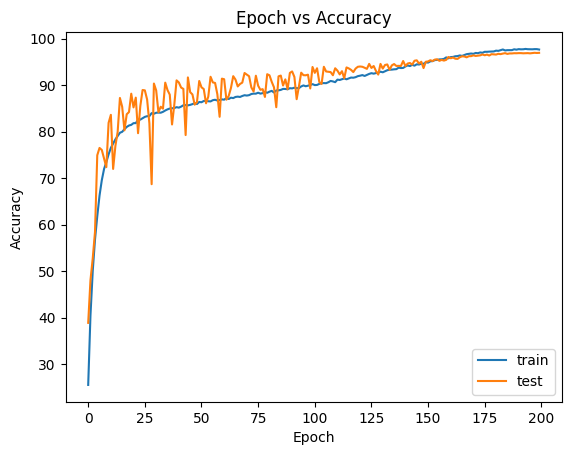

In [20]:
plt.plot(arr_train_acc)
plt.plot(arr_test_acc)
plt.legend(["train","test"])
plt.title("Epoch vs Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

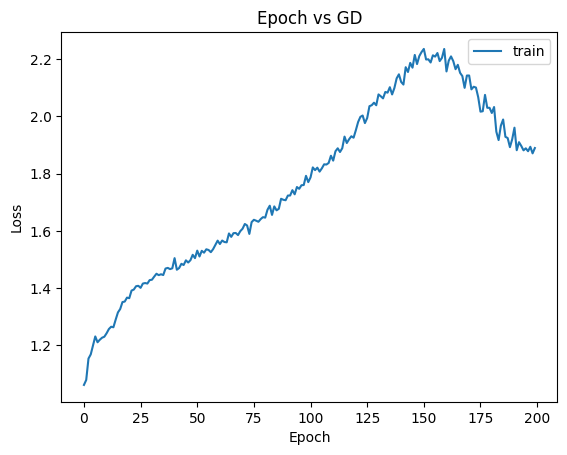

In [21]:
plt.plot(plot_gd_norm_fin)
# plt.plot(arr_test)
plt.legend(["train"])
plt.title("Epoch vs GD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

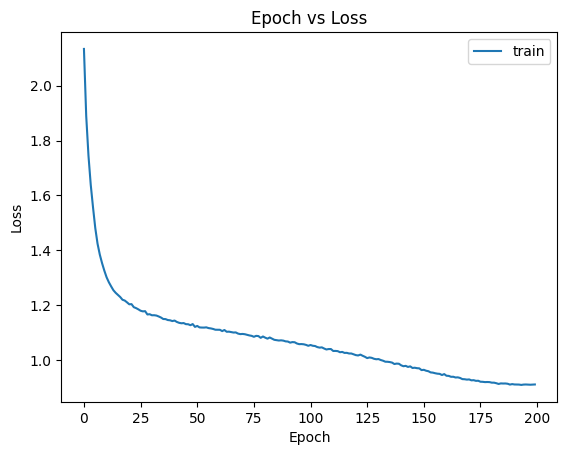

In [22]:
plt.plot(plot_train_loss_fin)
# plt.plot(arr_test)
plt.legend(["train"])
plt.title("Epoch vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

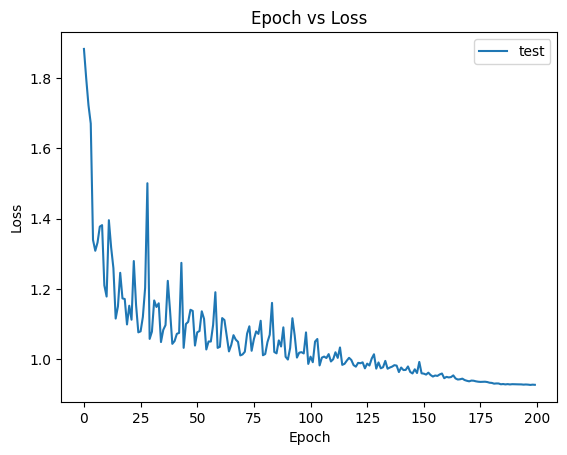

In [23]:
# plt.plot(arr_train1)
plt.plot(arr_test)
plt.legend(["test"])
plt.title("Epoch vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [24]:
model = torch.load("./Resnet_v23.pth")
model.to(device)

<ipython-input-24-76db2c9c81a2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("./Resnet_v23.pth")
/usr/local/lib/python3.10/dist-packages/torch/seriali

RecursiveScriptModule(
  original_name=ResNet
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (dropout): RecursiveScriptModule(original_name=Dropout)
  (layers): RecursiveScriptModule(
    original_name=ModuleList
    (0): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=BasicBlock
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (dropout): RecursiveScriptModule(original_name=Dropout)
        (conv2): RecursiveScriptModule(original_name=Conv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
        (shortcut): RecursiveScriptModule(original_name=Sequential)
      )
      (1): RecursiveScriptModule(
        original_name=BasicBlock
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
       

In [25]:
from torchvision.datasets.vision import VisionDataset
from typing import Any, Callable, Optional, Tuple, Union
from pathlib import Path
from PIL import Image
import pandas as pd

class Cifar10NoLabelDataset(VisionDataset):

    def __init__(
        self,
        root: Union[str, Path],
        transform: Optional[Callable] = None
    ) -> None:
        
        super().__init__(root, transform=transform, target_transform=None)

        self.data: Any = []
        self.targets = []
        
        with open(root, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')

        
        self.data = batch[b'data']
        self.targets = batch[b'ids']
        # self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        # self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img, target = self.data[index], self.targets[index]

        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [26]:
test_dataset_no_label = Cifar10NoLabelDataset(
    root='/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl',transform=transform_test)
valloader = torch.utils.data.DataLoader(
    test_dataset_no_label, batch_size=100, shuffle=False, num_workers=2)

In [27]:
indexes = []
predictions = []
for batch_idx, (inputs,index) in enumerate(valloader):
        inputs, index = inputs.to(device), index.to(device)
        indexes.extend(index.cpu().tolist())
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(torch.tensor(predicted).cpu().tolist())
        

dictionary = {'ID':indexes,'Label':predictions}
print(len(indexes))
print(len(predictions))

df = pd.DataFrame(dictionary)

<ipython-input-27-88534f9b886c>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions.extend(torch.tensor(predicted).cpu().tolist())


10000
10000


In [28]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

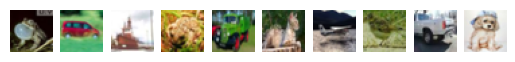

In [29]:
import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(test_dataset_no_label.data[i])
    plt.axis('off')
plt.show()


In [30]:
df.loc[0:9]

,ID,Label
0,0,6
1,1,1
2,2,8
3,3,6
4,4,9
5,5,3
6,6,0
7,7,2
8,8,9
9,9,5


In [31]:
df.to_csv('out.csv',index=False)